In [1]:
import time
import scipy.io
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import argparse
import pickle
import seaborn as sb

from utils import read_json
from utils import create_multi_window_input
from models import Siamese_SCC

In [2]:
def val_model(model, test_dl, device):
    criterion_mse = nn.MSELoss(reduction='mean')
    total_loss = 0
    output = []

    with torch.no_grad():
        model.eval()
        for x_test, y_test in test_dl:

            x_test, y_test = torch.flatten(x_test, 0, 1).to(device), torch.flatten(y_test, 0, 1).to(device)
            _, di, delta_di = model(x_test)
            
            mse = criterion_mse(delta_di, y_test[:,0]-y_test[:,1])
            rmse = sqrt(mse)
            cc = np.corrcoef((y_test[:,0]-y_test[:,1]).cpu().detach().numpy().reshape(-1), delta_di.cpu().detach().numpy().reshape(-1))

    return mse, rmse, cc[0,1] 

In [3]:
from torch import from_numpy as np2TT
from torch.utils.data import DataLoader, Dataset

In [5]:
class Pair_Dataloader(Dataset):
    def __init__(self, data, truth, session, mode, cfg):
        self.data = data
        self.truth = truth
        self.session = session
        self.mode = mode
        self.bs_index = 0
        self.pairing = cfg['pairing']

    def __len__(self):
        return len(self.data)		

    def __getitem__(self, index):
        x = self.data[index]
        y = self.truth[index].view(1, 1)
        # print(x.size())
        # print(y.device)
        if self.mode=='train':
            population = range(self.session[index][0], self.session[index][1])
            sample_idx = random.sample(population, self.pairing)
        elif self.mode =='test':
            sample_idx = [self.bs_index]
        else:
            raise ValueError('Invalid mode')

        pair = []
        label = []
        for i in range(len(sample_idx)):
            sample_data = self.data[sample_idx[i]]
            sample_truth = self.truth[sample_idx[i]].view(1,1)

            pair.append(torch.cat((sample_data, x), 0))
            label.append(torch.cat((y, sample_truth), 0))

        x_pair = torch.stack(pair)
        label_pair = torch.stack(label)

        return x_pair, label_pair

## Train the model and collect the gradient of input from both alert and drowsy trial

In [59]:
cfg = read_json('config/config_viz.json')
device = "cuda:0"

filelist = sorted(os.listdir(cfg['data_dir']))
drowsy_grad_dict = {}
alert_grad_dict = {}
all_grad_dict = {}

# sample_data = "s41_091104n.mat"
for s in filelist:
    if not s.endswith('.mat'):
        continue

    train_data, train_truth, tr_session_bound, _, _ = create_multi_window_input(s, 0, cfg)

    train_data = np.array(train_data, dtype=np.float32)
    train_truth = np.array(train_truth, dtype=np.float32)

    x_train = np2TT(train_data)
    y_train = np2TT(train_truth)
    train_dataset = Pair_Dataloader(x_train, y_train, tr_session_bound, 'test', cfg)
    train_dl = DataLoader(
        dataset = train_dataset,
        batch_size = cfg["batch_size"],
        shuffle = cfg["shuffle"] == 'True',
        num_workers = 4,
        pin_memory=True
    )
    test_dl = DataLoader(
        dataset = train_dataset,
        batch_size = len(train_dataset),
        shuffle = False,
        num_workers = 4,
        pin_memory=True
    )
    model = Siamese_SCC(cfg).to(device)
    optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    criterion = nn.MSELoss(reduction='mean')
    #lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
    record = {'train loss': [], 'val loss':[]}
    total_loss = 0
    
    drowsy_grad_acc = torch.zeros((10,30,750))
    alert_grad_acc = torch.zeros((10,30,750))
    all_grad_acc = torch.zeros((10,30,750))
    threshold_drowsy = np.quantile(train_truth, 0.85)
    threshold_alert = np.quantile(train_truth, 0.15)
    
    print(f"{s[:-4]} || threshold (alertness): {threshold_alert} threshold (drowsiness): {threshold_drowsy}")
    for epoch in range(cfg['epoch']):
        model.train()
        for x_train, y_train in train_dl:
            
            optimizer.zero_grad()
                
            x_train, y_train = torch.flatten(x_train, 0, 1).to(device), torch.flatten(y_train, 0,1).to(device)
            x_train.requires_grad = True
            _, di, delta_di = model(x_train)
            

            truth = y_train[:, 0] - y_train[:, 1]
            loss = criterion(delta_di, truth)
            total_loss += loss.detach().cpu().item()
            loss.backward(retain_graph=True)
            
            all_grad = x_train.grad
            all_grad = all_grad[:, 10:, :]
            all_grad_acc += torch.sum(all_grad.cpu(), 0)

            drowsy_grad = x_train.grad[(y_train[:, 0] >= threshold_drowsy).view(-1)]
            drowsy_grad = drowsy_grad[:, 10:, :, :]
            drowsy_grad_acc += torch.sum(drowsy_grad.cpu(), 0)
            
            alert_grad = x_train.grad[(y_train[:, 0] <= threshold_alert).view(-1)]
            alert_grad = alert_grad[:, 10:, :, :]
            alert_grad_acc += torch.sum(alert_grad.cpu(), 0)
            
            optimizer.step()
            #lr_scheduler.step()

        val_loss, rmse, cc = val_model(model, test_dl, device)
        record["train loss"].append(total_loss/len(train_dl.dataset))
        record["val loss"].append(val_loss)

        print(f"[{epoch+1}/{cfg['epoch']}] epoch: train loss-> {total_loss/len(train_dl.dataset)}")
        print(f"val loss-> {val_loss} rmse -> {rmse} cc -> {cc}")
        
    drowsy_grad_dict[s[:-4]] = drowsy_grad_acc
    alert_grad_dict[s[:-4]] = alert_grad_acc
    all_grad_dict[s[:-4]] = all_grad_acc
    
with open('drowsy_grad.plk', 'wb') as f:
    pickle.dump(drowsy_grad_dict, f)
    
with open('alert_grad.pkl', 'wb') as f:
    pickle.dump(alert_grad_dict, f)
    
with open('all_grad.pkl', 'wb') as f:
    pickle.dump(all_grad_dict, f)

s01_060926_2n || threshold (alertness): 0.03207246772944927 threshold (drowsiness): 0.2568514823913574
[1/30] epoch: train loss-> 0.0043730073577413955
val loss-> 0.04034038633108139 rmse -> 0.2008491631326389 cc -> 0.33665597994134405
[2/30] epoch: train loss-> 0.005556182327369849
val loss-> 0.021317820996046066 rmse -> 0.14600623615464534 cc -> 0.5219511850859034
[3/30] epoch: train loss-> 0.0065557138637329145
val loss-> 0.018098434433341026 rmse -> 0.13453042196224996 cc -> 0.6011390079735038
[4/30] epoch: train loss-> 0.007502735289745033
val loss-> 0.017100928351283073 rmse -> 0.1307705178978927 cc -> 0.6460997351724495
[5/30] epoch: train loss-> 0.008496073226754865
val loss-> 0.01827397756278515 rmse -> 0.1351812766724192 cc -> 0.6920292706327273
[6/30] epoch: train loss-> 0.009251662977039814
val loss-> 0.013347787782549858 rmse -> 0.11553262648511829 cc -> 0.7046932609264027
[7/30] epoch: train loss-> 0.009911468673186997
val loss-> 0.012137144804000854 rmse -> 0.11016871063

[1/30] epoch: train loss-> 0.005950602218614553
val loss-> 0.024612411856651306 rmse -> 0.15688343397775084 cc -> 0.5845854534755038
[2/30] epoch: train loss-> 0.0068081908049696886
val loss-> 0.012688996270298958 rmse -> 0.11264544496027773 cc -> 0.6646894288886073
[3/30] epoch: train loss-> 0.007427303177378649
val loss-> 0.011247009038925171 rmse -> 0.1060519167149994 cc -> 0.6872293232309387
[4/30] epoch: train loss-> 0.008005272439649243
val loss-> 0.011097176931798458 rmse -> 0.10534313898777868 cc -> 0.7104704621418813
[5/30] epoch: train loss-> 0.008594487844013864
val loss-> 0.010761536657810211 rmse -> 0.10373782655237293 cc -> 0.7326561001112248
[6/30] epoch: train loss-> 0.009101762431038713
val loss-> 0.010000884532928467 rmse -> 0.10000442256684684 cc -> 0.7537757978453182
[7/30] epoch: train loss-> 0.009619262648894537
val loss-> 0.011424340307712555 rmse -> 0.10688470567725092 cc -> 0.7691917521711068
[8/30] epoch: train loss-> 0.010087982453776269
val loss-> 0.00834586

[1/30] epoch: train loss-> 0.005835308979509929
val loss-> 0.1091153621673584 rmse -> 0.33032614514651787 cc -> 0.6107902785056092
[2/30] epoch: train loss-> 0.010042186535104027
val loss-> 0.03629624471068382 rmse -> 0.1905157334990573 cc -> 0.7118427618948504
[3/30] epoch: train loss-> 0.01215794633595304
val loss-> 0.04141703620553017 rmse -> 0.2035117593789857 cc -> 0.7429266561637898
[4/30] epoch: train loss-> 0.01403403718170174
val loss-> 0.039694011211395264 rmse -> 0.19923355945069912 cc -> 0.7632904810449481
[5/30] epoch: train loss-> 0.015728419334445586
val loss-> 0.026412248611450195 rmse -> 0.1625184562179022 cc -> 0.7835216382778288
[6/30] epoch: train loss-> 0.017277371476524035
val loss-> 0.03304899483919144 rmse -> 0.18179382508542868 cc -> 0.8033028014358503
[7/30] epoch: train loss-> 0.018676062986025765
val loss-> 0.024197984486818314 rmse -> 0.1555570136214318 cc -> 0.8143200801230243
[8/30] epoch: train loss-> 0.019837222525111123
val loss-> 0.021910926327109337 

[2/30] epoch: train loss-> 0.003058754860561479
val loss-> 0.01305906567722559 rmse -> 0.11427626909041785 cc -> 0.7187561837633214
[3/30] epoch: train loss-> 0.0037197096540627105
val loss-> 0.013233663514256477 rmse -> 0.11503766128645208 cc -> 0.7520337602232013
[4/30] epoch: train loss-> 0.004514113443696665
val loss-> 0.011779552325606346 rmse -> 0.10853364605322327 cc -> 0.777630987830822
[5/30] epoch: train loss-> 0.005092097966598324
val loss-> 0.013783353380858898 rmse -> 0.11740252714851968 cc -> 0.7944572852132111
[6/30] epoch: train loss-> 0.0056465534869880405
val loss-> 0.009323672391474247 rmse -> 0.09655916523807695 cc -> 0.8136179395822902
[7/30] epoch: train loss-> 0.006190705386185904
val loss-> 0.011597027070820332 rmse -> 0.10768949378105708 cc -> 0.8267406910027377
[8/30] epoch: train loss-> 0.0068440578064455845
val loss-> 0.008330978453159332 rmse -> 0.09127419379627152 cc -> 0.8376669471443144
[9/30] epoch: train loss-> 0.007301792696428795
val loss-> 0.0079950

[3/30] epoch: train loss-> 0.0029433536777648296
val loss-> 0.012047040276229382 rmse -> 0.1097590100002245 cc -> 0.8215639125683484
[4/30] epoch: train loss-> 0.0034689581980597477
val loss-> 0.00929764099419117 rmse -> 0.09642427595886406 cc -> 0.8448283671103384
[5/30] epoch: train loss-> 0.003974191911643732
val loss-> 0.010489064268767834 rmse -> 0.10241613285399832 cc -> 0.8531372979036449
[6/30] epoch: train loss-> 0.004403913761268226
val loss-> 0.011466911993920803 rmse -> 0.10708366819417797 cc -> 0.8773107207899964
[7/30] epoch: train loss-> 0.00483637270305983
val loss-> 0.007062911055982113 rmse -> 0.08404112716986911 cc -> 0.8887737011543895
[8/30] epoch: train loss-> 0.005194495720126235
val loss-> 0.006169445812702179 rmse -> 0.07854581982958851 cc -> 0.8990689064079991
[9/30] epoch: train loss-> 0.005511438024042564
val loss-> 0.005868635140359402 rmse -> 0.07660701756601285 cc -> 0.9090640232441507
[10/30] epoch: train loss-> 0.005827181990508711
val loss-> 0.00629990

[3/30] epoch: train loss-> 0.006947548764873183
val loss-> 0.014182275161147118 rmse -> 0.1190893578836796 cc -> 0.839558834266017
[4/30] epoch: train loss-> 0.0075110602125699364
val loss-> 0.009234383702278137 rmse -> 0.09609570074815073 cc -> 0.8602738883189721
[5/30] epoch: train loss-> 0.008017315793886138
val loss-> 0.008333253674209118 rmse -> 0.09128665660549255 cc -> 0.8763028930112706
[6/30] epoch: train loss-> 0.008489353771620769
val loss-> 0.008449078537523746 rmse -> 0.09191886932248322 cc -> 0.8876211848417525
[7/30] epoch: train loss-> 0.008923752159398564
val loss-> 0.0071411700919270515 rmse -> 0.08450544415555161 cc -> 0.895466252682676
[8/30] epoch: train loss-> 0.009317772418237166
val loss-> 0.006823990494012833 rmse -> 0.08260744817516658 cc -> 0.9032966410235065
[9/30] epoch: train loss-> 0.009753012776799514
val loss-> 0.006505180150270462 rmse -> 0.0806546970130721 cc -> 0.9024961738879632
[10/30] epoch: train loss-> 0.010157180748983575
val loss-> 0.006433659

[3/30] epoch: train loss-> 0.004823868772724555
val loss-> 0.013044465333223343 rmse -> 0.11421236944054415 cc -> 0.8493044503909238
[4/30] epoch: train loss-> 0.005445930026232814
val loss-> 0.00892103835940361 rmse -> 0.09445124858573131 cc -> 0.8647353357791494
[5/30] epoch: train loss-> 0.005909873358137742
val loss-> 0.014225994236767292 rmse -> 0.11927277240329115 cc -> 0.8808740123025846
[6/30] epoch: train loss-> 0.006451844971630408
val loss-> 0.01260659471154213 rmse -> 0.11227909294050309 cc -> 0.8831334287424845
[7/30] epoch: train loss-> 0.006871449921003819
val loss-> 0.008470750413835049 rmse -> 0.09203667971974569 cc -> 0.8933975886156825
[8/30] epoch: train loss-> 0.007286275247019807
val loss-> 0.008974508382380009 rmse -> 0.09473388191338941 cc -> 0.8994761590789825
[9/30] epoch: train loss-> 0.0077279855082691695
val loss-> 0.007663398515433073 rmse -> 0.08754083912913488 cc -> 0.9017509213707519
[10/30] epoch: train loss-> 0.008111511331542835
val loss-> 0.00655117

[3/30] epoch: train loss-> 0.00439607926956819
val loss-> 0.012972764670848846 rmse -> 0.113898045070356 cc -> 0.570584232485615
[4/30] epoch: train loss-> 0.005005245040922783
val loss-> 0.01010794285684824 rmse -> 0.1005382656347733 cc -> 0.6136408341553566
[5/30] epoch: train loss-> 0.005573735832136549
val loss-> 0.014115992933511734 rmse -> 0.11881074418381418 cc -> 0.6501311609941878
[6/30] epoch: train loss-> 0.0062139560229310924
val loss-> 0.03043731115758419 rmse -> 0.174462922013774 cc -> 0.6669123625122813
[7/30] epoch: train loss-> 0.006926232025051194
val loss-> 0.008354638703167439 rmse -> 0.0914037127427953 cc -> 0.6947413747578997
[8/30] epoch: train loss-> 0.0074098455322753895
val loss-> 0.00809145625680685 rmse -> 0.0899525222370493 cc -> 0.7150894519093772
[9/30] epoch: train loss-> 0.007964007467865634
val loss-> 0.00775383273139596 rmse -> 0.08805585006912352 cc -> 0.7320201964481345
[10/30] epoch: train loss-> 0.008383441221247014
val loss-> 0.0086134634912014 r

[4/30] epoch: train loss-> 0.004549784748545312
val loss-> 0.021858276799321175 rmse -> 0.14784544903148414 cc -> 0.8434247641932647
[5/30] epoch: train loss-> 0.005337068475746913
val loss-> 0.029475167393684387 rmse -> 0.17168333464167215 cc -> 0.8558265343675662
[6/30] epoch: train loss-> 0.005998935486625117
val loss-> 0.01338945422321558 rmse -> 0.11571280924433379 cc -> 0.8707630920976023
[7/30] epoch: train loss-> 0.006510266500190764
val loss-> 0.009493430145084858 rmse -> 0.09743423497459637 cc -> 0.8790888384574412
[8/30] epoch: train loss-> 0.007031523605941662
val loss-> 0.008708877488970757 rmse -> 0.09332136673329831 cc -> 0.8946110923697975
[9/30] epoch: train loss-> 0.00751256147753735
val loss-> 0.008476235903799534 rmse -> 0.09206647546093819 cc -> 0.8941353327799023
[10/30] epoch: train loss-> 0.007937499703605692
val loss-> 0.007733034435659647 rmse -> 0.08793767358566888 cc -> 0.9065820695844377
[11/30] epoch: train loss-> 0.008376527370428342
val loss-> 0.00758038

[5/30] epoch: train loss-> 0.005999684722360208
val loss-> 0.009256509132683277 rmse -> 0.09621075372682243 cc -> 0.8003719848928385
[6/30] epoch: train loss-> 0.006393081138280378
val loss-> 0.008551008999347687 rmse -> 0.0924716659271784 cc -> 0.8189885977296005
[7/30] epoch: train loss-> 0.00676876679378964
val loss-> 0.01901327446103096 rmse -> 0.13788863064455661 cc -> 0.8375622342888117
[8/30] epoch: train loss-> 0.007211028988300401
val loss-> 0.005166346672922373 rmse -> 0.07187730290517566 cc -> 0.8486485469409781
[9/30] epoch: train loss-> 0.007474420394856987
val loss-> 0.005481753032654524 rmse -> 0.07403886163802442 cc -> 0.8626488831823579
[10/30] epoch: train loss-> 0.007706542314137442
val loss-> 0.005178277846425772 rmse -> 0.0719602518507667 cc -> 0.8722438830227847
[11/30] epoch: train loss-> 0.00793797350383506
val loss-> 0.008344433270394802 rmse -> 0.09134786954491496 cc -> 0.8841718779840837
[12/30] epoch: train loss-> 0.008197804112621252
val loss-> 0.0044824779

[5/30] epoch: train loss-> 0.005719081372717483
val loss-> 0.010136930271983147 rmse -> 0.10068232353289801 cc -> 0.9420743400172255
[6/30] epoch: train loss-> 0.006265057156724652
val loss-> 0.0095555130392313 rmse -> 0.09775230452133239 cc -> 0.943895472663582
[7/30] epoch: train loss-> 0.006781231675631716
val loss-> 0.009094828739762306 rmse -> 0.09536681152142136 cc -> 0.9490851031555013
[8/30] epoch: train loss-> 0.0072431537137163104
val loss-> 0.010485579259693623 rmse -> 0.10239911747516979 cc -> 0.9564465087983065
[9/30] epoch: train loss-> 0.007760847795907466
val loss-> 0.007374339736998081 rmse -> 0.08587397590072374 cc -> 0.9574123637363935
[10/30] epoch: train loss-> 0.008170089965915395
val loss-> 0.007991339080035686 rmse -> 0.08939428997444795 cc -> 0.9570563737196591
[11/30] epoch: train loss-> 0.00860021567586955
val loss-> 0.007134336978197098 rmse -> 0.08446500445863421 cc -> 0.96082307270018
[12/30] epoch: train loss-> 0.008959459325978969
val loss-> 0.0062755104

[5/30] epoch: train loss-> 0.0057835666411131465
val loss-> 0.01128830574452877 rmse -> 0.10624643873809969 cc -> 0.9522204165348779
[6/30] epoch: train loss-> 0.006272838089435173
val loss-> 0.008515940979123116 rmse -> 0.0922818561751069 cc -> 0.9554870734769689
[7/30] epoch: train loss-> 0.0067232429484748455
val loss-> 0.007515621371567249 rmse -> 0.08669268349501733 cc -> 0.9580252506041665
[8/30] epoch: train loss-> 0.007121733561814604
val loss-> 0.007457613479346037 rmse -> 0.08635747494771971 cc -> 0.9608596348300752
[9/30] epoch: train loss-> 0.007560002936170251
val loss-> 0.013245767913758755 rmse -> 0.11509025985616139 cc -> 0.964559381735058
[10/30] epoch: train loss-> 0.008059187766834295
val loss-> 0.010393856093287468 rmse -> 0.1019502628406983 cc -> 0.9648474309180579
[11/30] epoch: train loss-> 0.008474981146556374
val loss-> 0.006343440152704716 rmse -> 0.07964571647430084 cc -> 0.9661419749508745
[12/30] epoch: train loss-> 0.008801558065812948
val loss-> 0.0064042

[5/30] epoch: train loss-> 0.010346985932869406
val loss-> 0.021201759576797485 rmse -> 0.14560824007176754 cc -> 0.884449601428825
[6/30] epoch: train loss-> 0.01095600689904621
val loss-> 0.014438394457101822 rmse -> 0.1201598704106401 cc -> 0.8990992515413675
[7/30] epoch: train loss-> 0.011367834624476159
val loss-> 0.007760379463434219 rmse -> 0.08809301597422023 cc -> 0.9110608899687573
[8/30] epoch: train loss-> 0.011729331836820796
val loss-> 0.014100462198257446 rmse -> 0.11874536706018238 cc -> 0.9184748067966779
[9/30] epoch: train loss-> 0.012308435993484006
val loss-> 0.010091151110827923 rmse -> 0.10045472169503991 cc -> 0.9181567927812061
[10/30] epoch: train loss-> 0.012630174113795734
val loss-> 0.004935352597385645 rmse -> 0.07025206471973365 cc -> 0.9346890457030884
[11/30] epoch: train loss-> 0.012969809244745053
val loss-> 0.007273017428815365 rmse -> 0.08528198771613714 cc -> 0.9269027731049042
[12/30] epoch: train loss-> 0.01326205209399072
val loss-> 0.005114279

[6/30] epoch: train loss-> 0.00862426668755868
val loss-> 0.015844473615288734 rmse -> 0.12587483312913958 cc -> 0.8687930013168672
[7/30] epoch: train loss-> 0.009243424362297784
val loss-> 0.011110438033938408 rmse -> 0.10540606260523352 cc -> 0.8822508401838495
[8/30] epoch: train loss-> 0.00981828541873125
val loss-> 0.010927723720669746 rmse -> 0.1045357533127769 cc -> 0.8869008039559876
[9/30] epoch: train loss-> 0.010350311498162531
val loss-> 0.009826879017055035 rmse -> 0.0991306159420743 cc -> 0.8911294025799832
[10/30] epoch: train loss-> 0.010906619882998549
val loss-> 0.021141299977898598 rmse -> 0.14540048135373762 cc -> 0.8929712231251292
[11/30] epoch: train loss-> 0.011641063666976113
val loss-> 0.009539658203721046 rmse -> 0.09767117386271676 cc -> 0.8950585229431662
[12/30] epoch: train loss-> 0.012288219357204238
val loss-> 0.012983840890228748 rmse -> 0.1139466580915331 cc -> 0.9024130683872915
[13/30] epoch: train loss-> 0.012927528131453193
val loss-> 0.009343942

In [9]:
with open('gradient/drowsy_grad_cross_baseline.pkl', 'rb') as fp:
    drowsy_grad_dict = pickle.load(fp)
with open('gradient/alert_grad_cross_baseline.pkl', 'rb') as fp:
    alert_grad_dict = pickle.load(fp)
with open('gradient/all_grad_cross_baseline.pkl', 'rb') as fp:
    all_grad_dict = pickle.load(fp)

## Import channel information and set montage

In [17]:
import mne 
sample_data = "/home/cecnl/ljchang/CECNL/sustained-attention/6427334/s01_061102n.set"
raw = mne.io.read_raw_eeglab(sample_data)
excluded = ['A1', 'A2', 'vehicle position']
new_ch = []
for ch in raw.ch_names:
    if ch not in excluded:
        new_ch.append(ch)

new_info = mne.create_info(ch_names = new_ch, sfreq=raw.info['sfreq'], ch_types=['eeg'] * 30)
raw.info = new_info

# montage data is store in mne package direction
mantage_dir = os.path.join(os.path.dirname(mne.__file__), 'montages')
# choose montage
ten_twenty_montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(ten_twenty_montage, match_case=False)


/tmp/ipykernel_30818/1630951146.py:3: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(sample_data)


<RawEEGLAB | s01_061102n.set, 30 x 3152140 (6304.3 s), ~793.7 MB, data loaded>

## Helper function for calculating band power for each channel

In [7]:
def get_band_power(g):
    g = torch.sum(torch.abs(g), 0).numpy()
    band_power = {}
    band_power['Alpha'] = np.zeros(30)
    band_power['Beta'] = np.zeros(30)
    band_power['Theta'] = np.zeros(30)
    band_power['Delta'] = np.zeros(30)
    vmin = 1
    vmax = 0
    for c in range(30):
        freqs, psd = signal.welch(g[c], fs=250)
        a = np.sum(psd[np.where(np.logical_and(freqs>8, freqs<=12))])
        b = np.sum(psd[np.where(np.logical_and(freqs>12, freqs<=16))])
        t = np.sum(psd[np.where(np.logical_and(freqs>4, freqs<=8))])
        d = np.sum(psd[np.where(np.logical_and(freqs>1, freqs<=4))])
        total = a + b + t + d
        band_power['Alpha'][c] = a / total
        band_power['Beta'][c] = b / total
        band_power['Theta'][c] = t / total
        band_power['Delta'][c] = d / total
        vmax = np.max([vmax, a/total , b/total, t/total, d/total])
        vmin = np.min([vmin, a/total , b/total, t/total, d/total])
    return band_power, vmax, vmin

## Plot the spatial and frequency distribution of gradient for each channel
Extract the PSD for each channel in the gradient response of input, and obtain the band-power from these 4 sub-band
- delta: 1~4
- theta: 4~8
- alpha: 8~12
- beta: 12~16

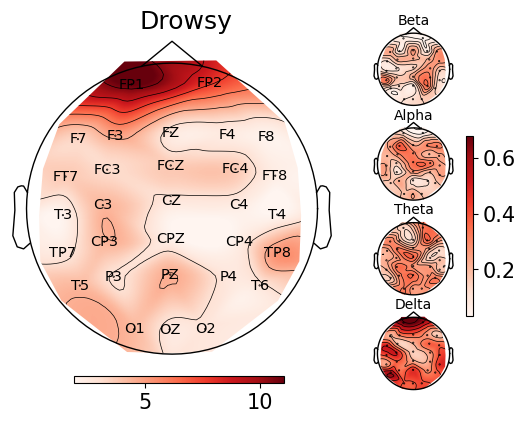

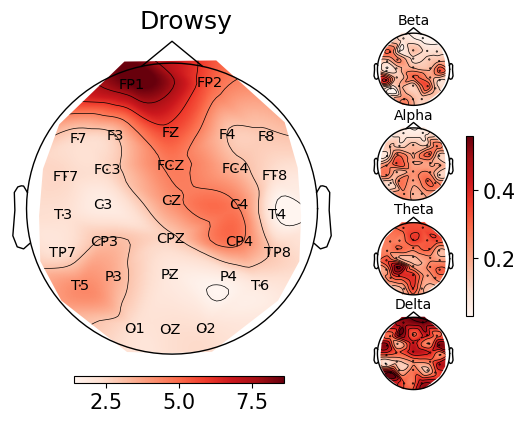

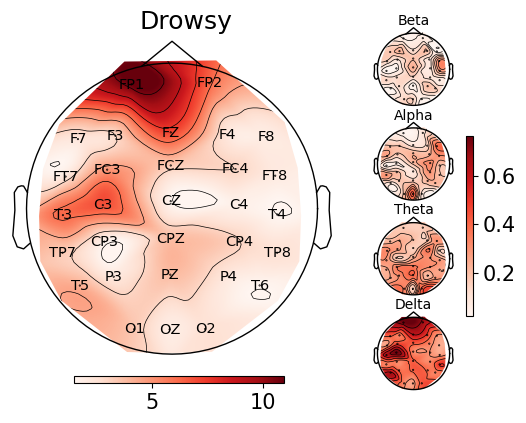

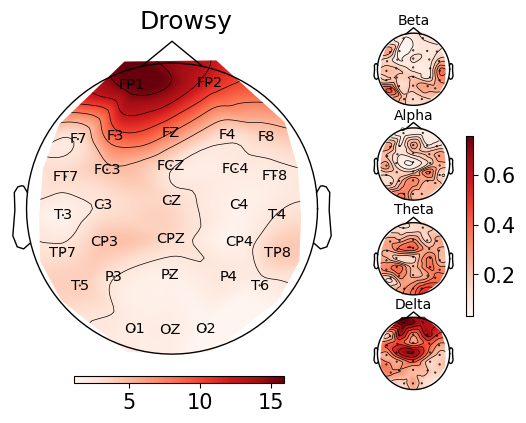

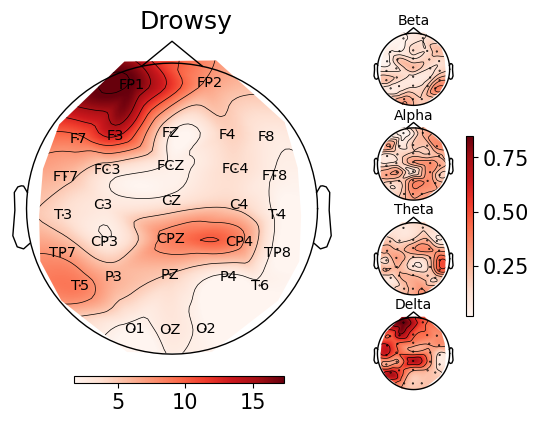

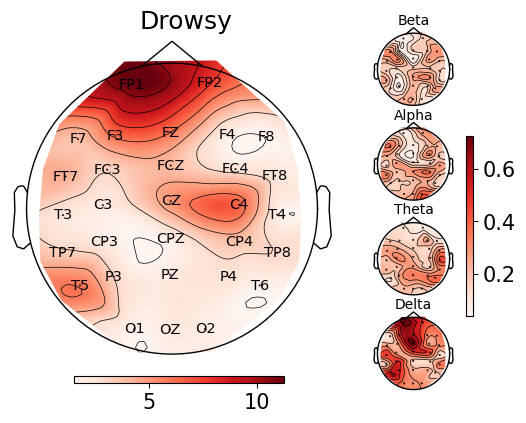

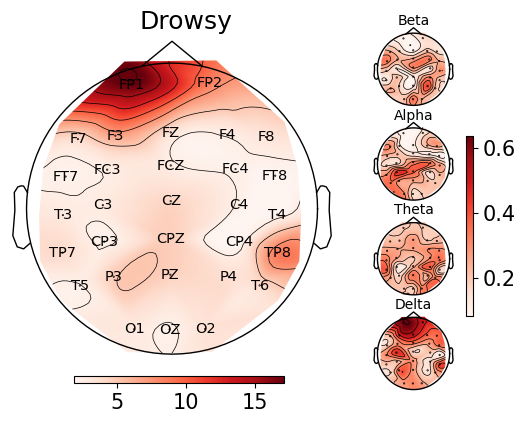

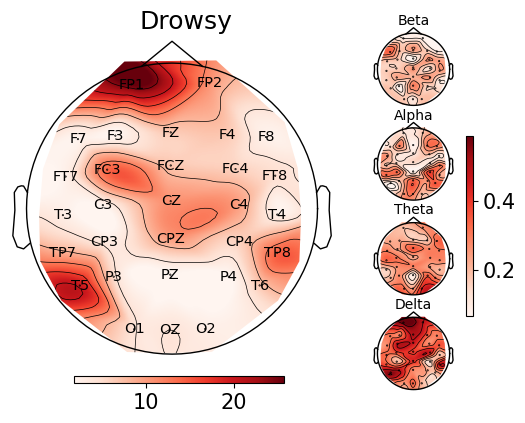

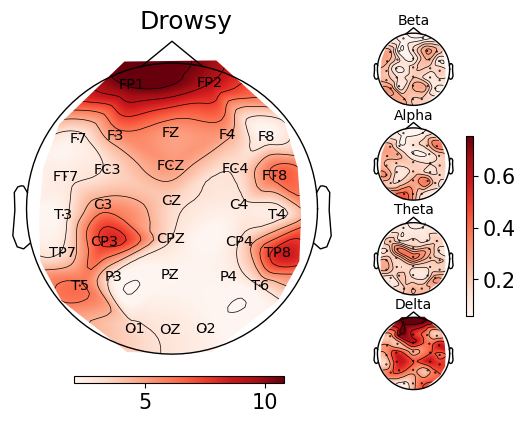

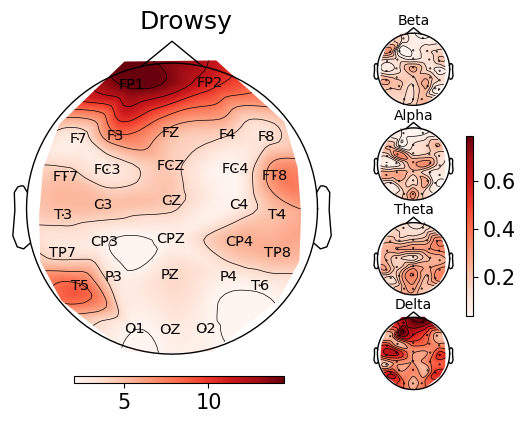

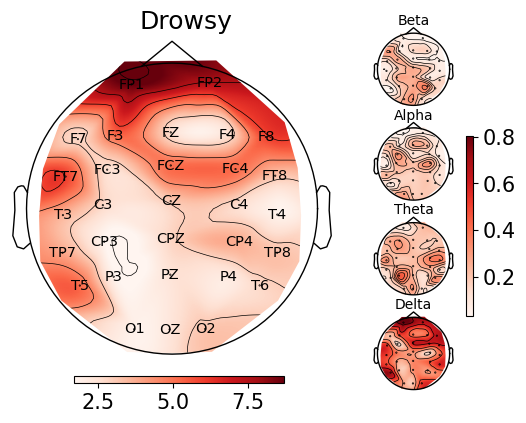

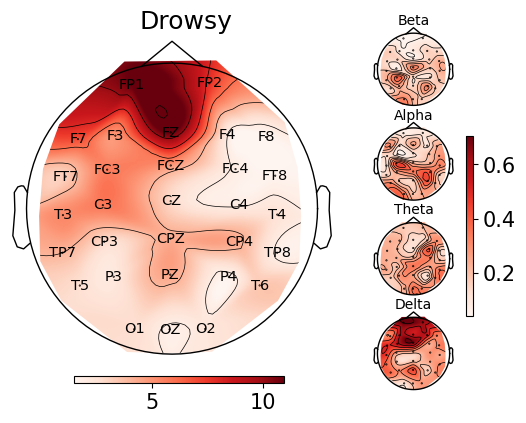

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal

# For drowsy samples 
for s, g in drowsy_grad_dict.items():
    band_power, vmax, vmin = get_band_power(g)
    g = torch.sum(torch.sum(torch.abs(g), 2), 0).numpy()
    
    # Plot the distribution of the graient on the scalp
    fig = plt.figure(figsize=(7, 4.5))
    plt.rc('font', size=15)
    plt.rc('legend', fontsize=16)
    plt.rc('axes', labelsize=20)
    outer = mpl.gridspec.GridSpec(1, 3, wspace=0.02, hspace=0.2, width_ratios=[3, 1, 0.5])
    ax = plt.Subplot(fig, outer[0])
    im, cn = mne.viz.plot_topomap(g, raw.info, names = raw.ch_names, axes = ax, 
                                  size = 3, res = 81, show = False, extrapolate = 'local', 
                                  vlim=(np.min(g), np.max(g)), sphere=(0,0.02,0,0.095))
    cbar_ax = fig.add_axes([0.24, 0.15, 0.3, 0.017])
    clb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    fig.add_subplot(ax)
    
    # Plot the sub-band power ratio of each channel
    inner = mpl.gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[1], wspace=0.1, hspace=0.01)
    band = ['Beta', 'Alpha', 'Theta', 'Delta']
    for i in range(4):
        ax = plt.Subplot(fig, inner[i])
        im,cm = mne.viz.plot_topomap(band_power[band[i]], raw.info, axes=ax, size=0.7,
                                     show=False, vlim = (vmin, vmax), extrapolate = 'local', sphere=(0,0.02,0,0.095))   
        ax.set_title(band[i], fontsize=10, y=1, pad=-1)
        fig.add_subplot(ax)
    
    cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.4])
    clb = fig.colorbar(im, cax=cbar_ax)
    
    fig.suptitle("Drowsy", x = 0.4)
    plt.savefig(f'visualization/saliency_map/cross_subject_baseline/drowsy_merged_{s}.png')

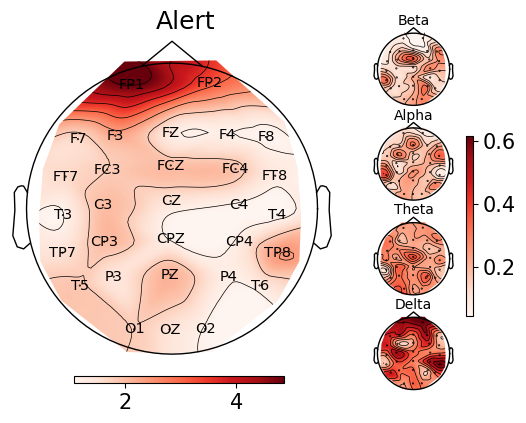

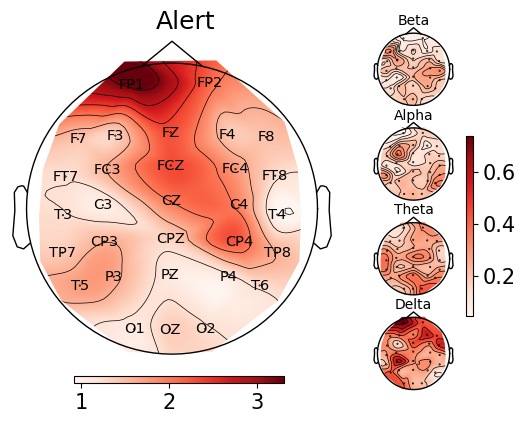

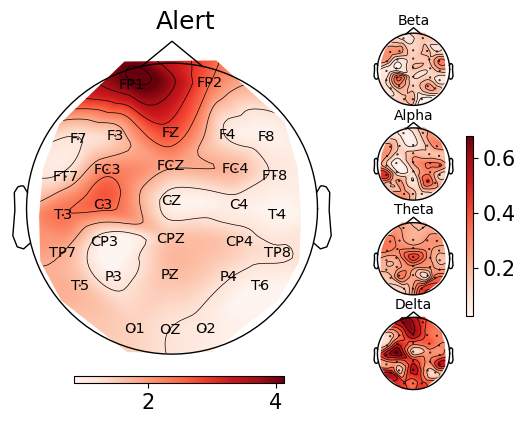

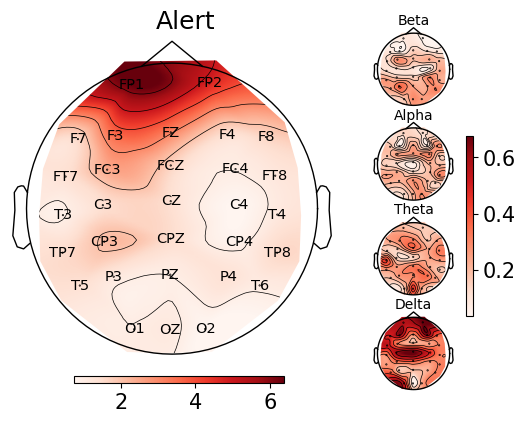

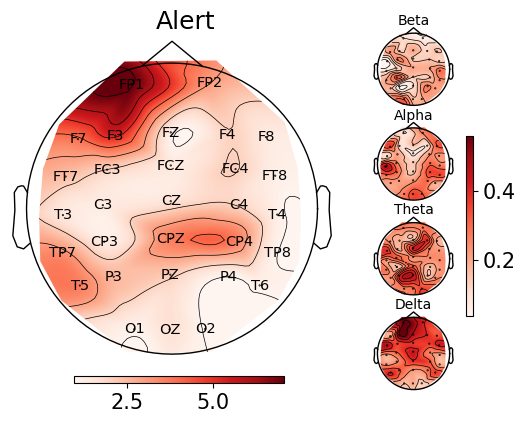

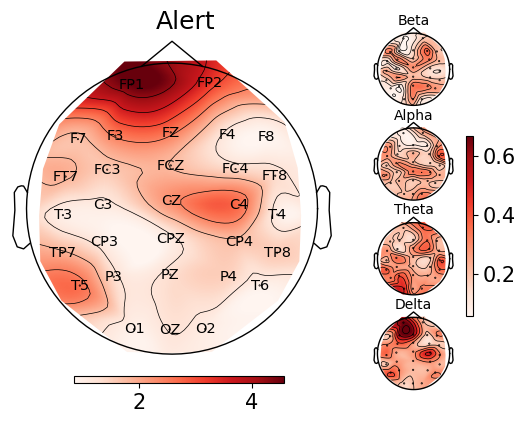

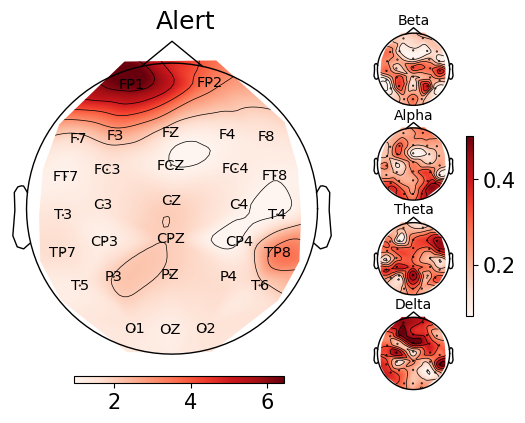

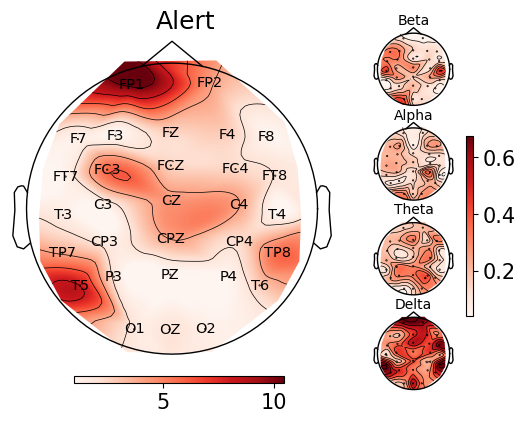

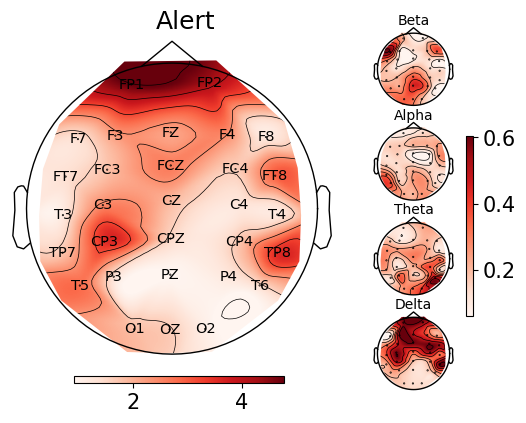

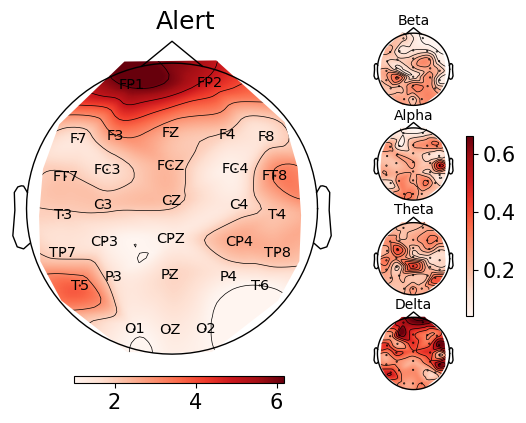

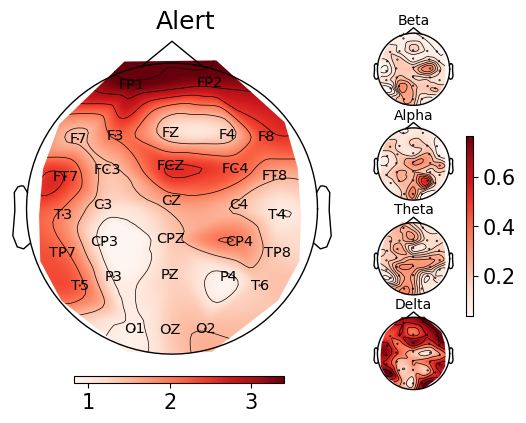

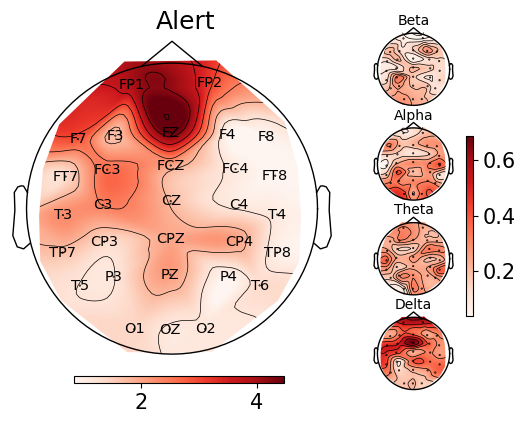

In [23]:
# For alert samples 
for s, g in alert_grad_dict.items():
    band_power, vmax, vmin = get_band_power(g)
    g = torch.sum(torch.sum(torch.abs(g), 2), 0).numpy()
    
    fig = plt.figure(figsize=(7, 4.5))
    outer = mpl.gridspec.GridSpec(1, 3, wspace=0.02, hspace=0.2, width_ratios=[3, 1, 0.5])
    ax = plt.Subplot(fig, outer[0])
    im, cn = mne.viz.plot_topomap(g, raw.info, names = raw.ch_names, axes = ax, 
                                  size = 3, res = 81, show = False, extrapolate = 'local', 
                                  vlim=(np.min(g), np.max(g)), sphere=(0,0.02,0,0.095))
    cbar_ax = fig.add_axes([0.24, 0.15, 0.3, 0.017])
    clb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    fig.add_subplot(ax)

    inner = mpl.gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[1], wspace=0.1, hspace=0.01)
    band = ['Beta', 'Alpha', 'Theta', 'Delta']
    for i in range(4):
        ax = plt.Subplot(fig, inner[i])
        im,cm = mne.viz.plot_topomap(band_power[band[i]], raw.info, axes=ax, size=0.7,
                                     show=False, vlim = (vmin, vmax), extrapolate = 'local', sphere=(0,0.02,0,0.095))   
        ax.set_title(band[i], fontsize=10, y=1, pad=-1)
        fig.add_subplot(ax)
    
    cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.4])
    clb = fig.colorbar(im, cax=cbar_ax)
    
   
    fig.suptitle("Alert", x = 0.4)
    plt.savefig(f'visualization/saliency_map/cross_subject_baseline/alert_merged_{s}.png')

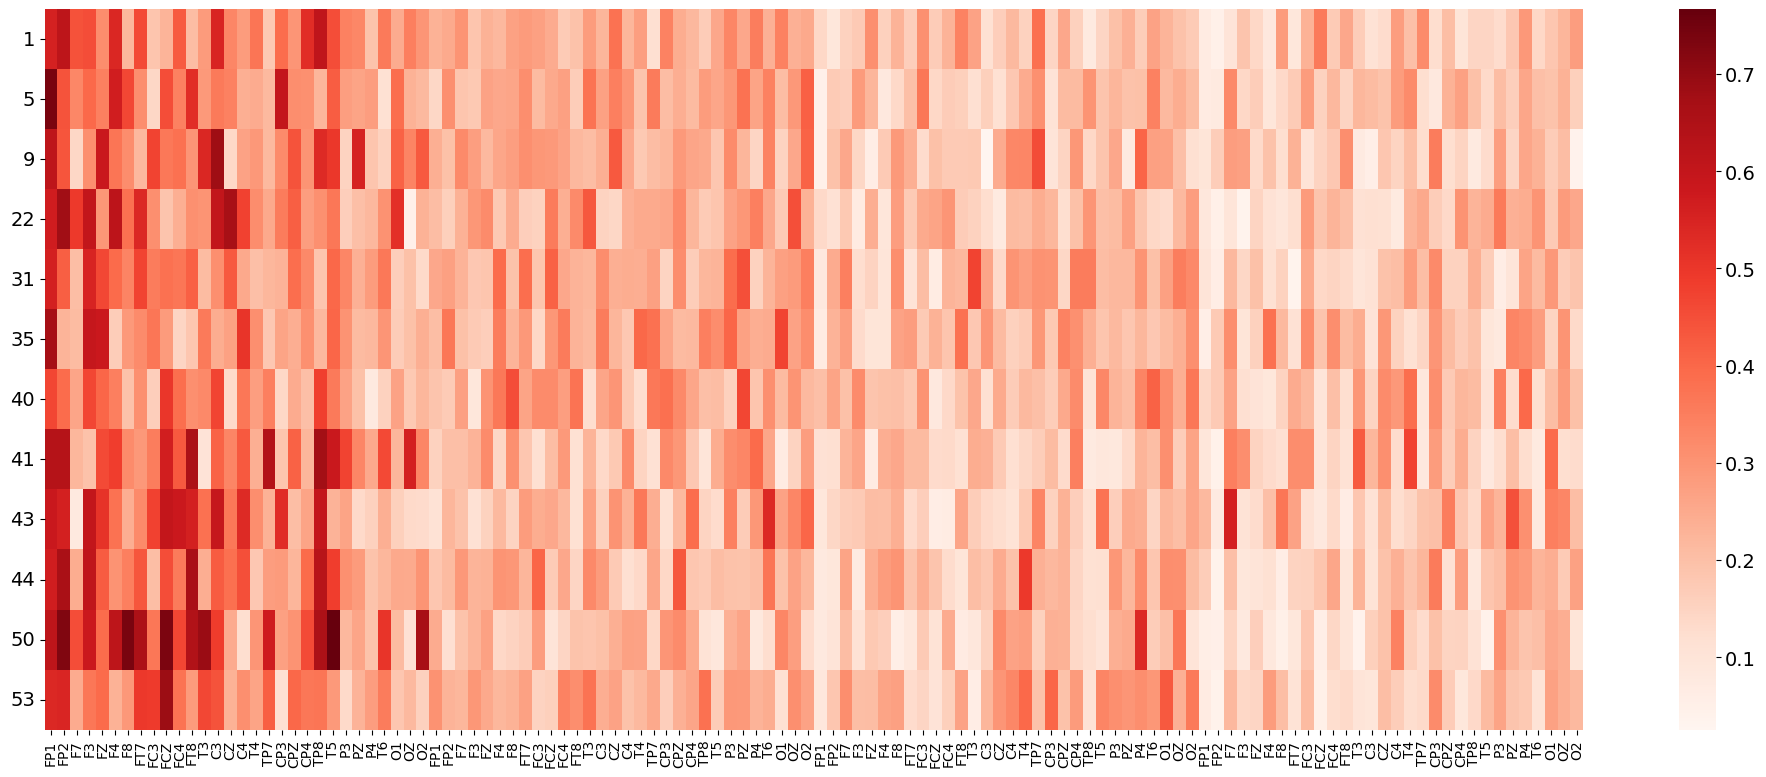

In [25]:
table = np.zeros((12, 120))
for i, (s, g) in enumerate(alert_grad_dict.items()):
    band_power, vmax, vmin = get_band_power(g)
    table[i,:30] = band_power['Delta']
    table[i,30:60] = band_power['Theta']
    table[i,60:90] = band_power['Alpha']
    table[i,90:120] = band_power['Beta']

ch_4band = np.tile(new_ch, 4)
plt.figure(figsize=(20,8))
plt.rc('font', size=14)
ax = sb.heatmap(table, cmap = mpl.colormaps['Reds'])
# plt.axis('off')
# ax.set_yticklabels(['1-1', '1-2', '5-1', '5-2', '9-1', '9-2', '22-1', 
#            '22-2', '22-3', '31-1', '35-1', '35-2', '40-1', 
#            '40-2', '41-1', '41-2', '41-3', '43-1', '43-2',
#            '43-3', '44-1', '44-2', '44-3', '50-1', '50-2', 
#            '53-1', '53-2', '53-3'], rotation=0, size=14)
ax.set_yticklabels(["1", "5", "9", "22", "31", "35", "40", "41", "43", "44", "50", "53"], rotation=0, size=14)
# ax.set_xticklabels(list(ch_4band))
plt.xticks([i-0.5 for i in range(1,121)], list(ch_4band), size=10)
plt.tight_layout()

In [116]:
[i-0.5 for i in range(1,11)]

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]

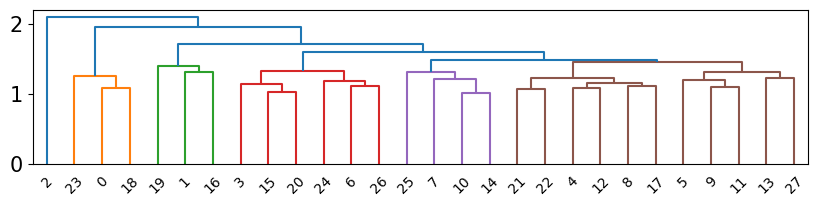

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10,2))
linkage_data = linkage(table, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

In [68]:
linkage_data

array([[10.        , 14.        ,  1.01503107,  2.        ],
       [15.        , 20.        ,  1.02628998,  2.        ],
       [21.        , 22.        ,  1.06620922,  2.        ],
       [ 0.        , 18.        ,  1.07641367,  2.        ],
       [ 4.        , 12.        ,  1.08128614,  2.        ],
       [ 9.        , 11.        ,  1.09119085,  2.        ],
       [ 8.        , 17.        ,  1.10644544,  2.        ],
       [ 6.        , 26.        ,  1.11350084,  2.        ],
       [ 3.        , 29.        ,  1.13893506,  3.        ],
       [32.        , 34.        ,  1.15648342,  4.        ],
       [24.        , 35.        ,  1.18352688,  3.        ],
       [ 5.        , 33.        ,  1.20031771,  3.        ],
       [ 7.        , 28.        ,  1.20518287,  3.        ],
       [13.        , 27.        ,  1.21836901,  2.        ],
       [30.        , 37.        ,  1.22315967,  6.        ],
       [23.        , 31.        ,  1.25461347,  3.        ],
       [ 1.        , 16.

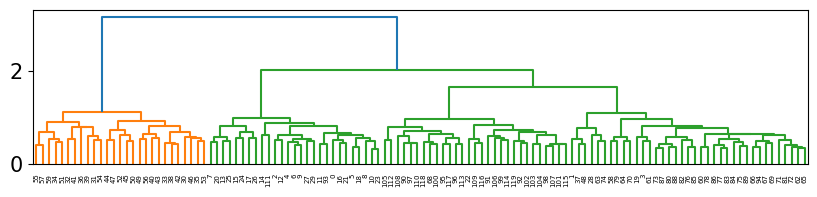

In [66]:
plt.figure(figsize=(10,2))
linkage_data = linkage(table.T, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()